# Curtailment From Eirgrid Data 

In [66]:
#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.environ import *
from pyomo.util.infeasible import log_infeasible_constraints
import logging
pd.options.mode.chained_assignment = None
width = 426.79135

In [67]:
df = pd.read_excel('data/Eirgrid_data_20_21.xlsx', index_col=0) #bring in the raw data, this is in MW
market_prices = pd.read_csv('data/market_price.csv')

C:\Users\shane\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,8,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [68]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

## Energy data

In [69]:
#Decided to use an all Island approach as they are intrinsincally linked

all_ireland = pd.DataFrame()

#Create new columns
all_ireland['Wind Availability'] = df['IE Wind Availability']+df['NI Wind Availability']
all_ireland['Wind Generation'] = df['IE Wind Generation']+df['NI Wind Generation']
all_ireland['Demand'] = df['IE Demand']+ df['NI Demand']
all_ireland['SNSP'] = df['SNSP']

#Not entirely sure yet if this is how to get wind curtailment, shouldn't have to do the negative thing
all_ireland['Curtailment'] = all_ireland['Wind Availability'] - all_ireland['Wind Generation'] 

#set negative values to 0
all_ireland[all_ireland < 0] = 0

#remake to hourly and choose 2019
all_ireland = all_ireland.resample('H').mean() #bring it from quarter hourly data to hourly, now in MWh
all_ireland = all_ireland[all_ireland.index.year.isin([2020])]
all_ireland = all_ireland.fillna(method='ffill') #in case there's missing data fill with next value in line


In [70]:
all_ireland['SNSP'].max() #This makes sense with whats in the report, was increased to 65%

0.66245

In [71]:
all_ireland['Wind Generation'].max()

4207.56625

In [72]:
per_dispactch_down = (all_ireland['Curtailment'].sum()/all_ireland['Wind Availability'].sum())*100
total_gen = round(all_ireland['Wind Generation'].sum()/1000,2)
total_dispatch_down = round(all_ireland['Curtailment'].sum()/1000,2)

print(total_gen, 11076) #so the over
print(total_dispatch_down, 707)
print('% dispatch down = {}'.format(round(per_dispactch_down,2)))


13698.8 11076
2089.07 707
% dispatch down = 13.23


In [73]:
print('Only {}% of dispatch down in this data makes it to the final report'.format(round(707/(all_ireland['Curtailment'].sum()/1000)*100,2)))

Only 33.84% of dispatch down in this data makes it to the final report


In [74]:
#Making these figures agree with what was in the report
scaling_factor = 12.1/per_dispactch_down
all_ireland['Curtailment'] = all_ireland['Curtailment']*scaling_factor

In [75]:
all_ireland['Curtailment'].sum() #closer now

1910155.488516

## Price data

In [76]:
#Start arranging the price data here, have only used the Day ahead market really
prices = market_prices[market_prices['auction'] == 'DAM']
prices.index = pd.to_datetime(prices['timestamp'])

In [77]:
prices = prices[prices.index.year.isin([2020])]
prices.index = all_ireland.index[0:8783]
all_ireland['Day Ahead Price'] = prices['price_eur']
all_ireland = all_ireland.dropna()

# Actual model

In [136]:
class storage:
    def __init__(self,capacity_cost,power_cost,efficiency,hours_of_storage,capacity,asset_life,power,
                self_discharge_rate=None):
        self.capacity_cost = capacity_cost
        self.power_cost = power_cost
        self.efficiency = efficiency
        self.hours_of_storage = hours_of_storage
        self.capacity = capacity
        self.power = power
        self.asset_life = asset_life
        self.self_discharge_rate = self_discharge_rate

In [137]:
#Define the different technologys
iron_air = storage(capacity_cost=10.75*1000,power_cost=1075,efficiency=.45,hours_of_storage=100,capacity=100,power=1000,
                   asset_life=10,self_discharge_rate=None)

li_ion = storage(capacity_cost=324*1000,power_cost=1296,efficiency=.9,hours_of_storage=4,capacity=100,power=1000,
                   asset_life=10,self_discharge_rate=None)

storage_ops = [iron_air, li_ion]
names = ['Iron-Air Battery', 'Lithium-Ion Battery']

In [138]:
class simulation:
    def __init__(self, data, storage):
        #This should bring in the data
        self.data = data
        self.storage = storage
    
    def run(self):
        self.data = self.data.dropna()
        self.data.index = range(1,len(self.data)+1)
        #Create the model
        model = ConcreteModel()

        #Everything will be done in timesteps
        model.t = RangeSet(len(self.data))

        #Define a few parameters that will model on the constraints
        model.e_available = Param(model.t, initialize=self.data['Curtailment'])
        model.efficiency = Param(initialize=self.storage.efficiency)
        model.price = Param(model.t, initialize=self.data['Day Ahead Price'])
        model.max_out = Param(model.t, initialize=self.data['Demand'] - self.data['Wind Generation'])

        #The variables of the problem
        model.charge = Var(model.t, domain=NonNegativeReals)
        model.e_in = Var(model.t, domain=NonNegativeReals) #this is the amount of energy not curtailed
        model.e_out = Var(model.t, domain=NonNegativeReals)
        model.capacity = Var(domain=NonNegativeReals) 
        model.power = Var(domain=NonNegativeReals)

        #The battery charge is equal to previous time step plus charge minus discharge, tick
        def state_of_charge(model,t):
            if t == 1:
                return model.charge[t] == 0
            else:
                return model.charge[t] == model.charge[t-1] + model.e_in[t-1]*model.efficiency - model.e_out[t-1]
        model.soc = Constraint(model.t, rule=state_of_charge)
        
        #Charge of the battery can't exceed the capacity, tick
        def max_charge(model, t):
            return model.charge[t] <= model.capacity
        model.max_charge = Constraint(model.t, rule=max_charge)

        #Power in can't exceed the rate limit combined with effiency, tick
        def power_in(model,t): 
            return model.e_in[t] <= model.power
        model.pow_in = Constraint(model.t, rule=power_in)
        
        #Power out can't exceed the rate limit combined with effiency, tick
        def power_out(model,t):
            return model.e_out[t] <= model.power
        model.pow_out = Constraint(model.t, rule=power_out)
        
        #Charging of the battery must be less than or equal to the amount of energy available
        def charging_con(model,t):
            return model.e_in[t] <= model.e_available[t]
        model.con1 = Constraint(model.t, rule=charging_con)
        
        #Discharging of the battery must be less than or equal to the amount of energy available
        def discharging_con(model,t): 
            return model.e_out[t] <= model.charge[t]
        model.con2 = Constraint(model.t, rule=discharging_con)
        
        #The hours of storage chosen must be less than or equal to the technology allows
        def storage_hours(model):
            return model.power == model.capacity/self.storage.hours_of_storage
        model.con3 = Constraint(rule=storage_hours)
        
        #Wanted to reduce the massive discharges, can only output demand - wind at once
        def max_output(model,t): 
            return model.e_out[t] <= model.max_out[t]
        model.con4 = Constraint(model.t, rule=max_output)
        
        #trying to define an optimal scenario
        
        #objective function, minimize the cost of the system. Want to include curtailment in some way
        profit = sum(model.price[t]*(model.e_available[t]-model.e_in[t]) for t in model.t) - sum(model.price[t]*model.e_out[t] for t in model.t) + self.storage.capacity_cost*model.capacity
        model.obj = Objective(expr=profit, sense=minimize)

        # Solve the model
        solver = SolverFactory('glpk')
        results = solver.solve(model, tee=True)
        
        return model


In [142]:
all_ireland = pd.concat([all_ireland]*10)

In [143]:
results = []

#for each storage option run the optimization
for x in storage_ops:
    sim = simulation(all_ireland, x)
    model = sim.run()
    results.append(model)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\shane\AppData\Local\Temp\tmp1wzw4qhs.glpk.raw --wglp C:\Users\shane\AppData\Local\Temp\tmpa_m5qoky.glpk.glp
 --cpxlp C:\Users\shane\AppData\Local\Temp\tmp63fzems9.pyomo.lp
Reading problem data from 'C:\Users\shane\AppData\Local\Temp\tmp63fzems9.pyomo.lp'...
614812 rows, 263493 columns, 1229620 non-zeros
3511678 lines were read
Writing problem data to 'C:\Users\shane\AppData\Local\Temp\tmpa_m5qoky.glpk.glp'...
2809031 lines were written
GLPK Simplex Optimizer 5.0
614812 rows, 263493 columns, 1229620 non-zeros
Preprocessing...
438657 rows, 263000 columns, 1052480 non-zeros
Scaling...
 A: min|aij| =  1.000e-02  max|aij| =  1.000e+00  ratio =  1.000e+02
GM: min|aij| =  4.940e-01  max|aij| =  2.024e+00  ratio =  4.098e+00
EQ: min|aij| =  2.440e-01  max|aij| =  1.000e+00  ratio =  4.098e+00
Constructing initial basis...
Size of triangular part is 438657
*     0: obj =   3.353763787e+08 inf =   0.000e

* 36581: obj =   3.284718293e+08 inf =   2.051e-13 (104633) 3
* 36868: obj =   3.284163091e+08 inf =   6.160e-14 (103499) 2
* 37196: obj =   3.282295393e+08 inf =   1.081e-13 (103650) 3
* 37494: obj =   3.280468703e+08 inf =   7.137e-13 (103595) 3
* 37827: obj =   3.279614213e+08 inf =   1.954e-14 (103658) 2
* 38148: obj =   3.278149727e+08 inf =   2.867e-13 (102955) 3
* 38459: obj =   3.274287373e+08 inf =   8.260e-13 (102686) 3
* 38713: obj =   3.273702497e+08 inf =   1.154e-13 (104074) 3
* 39008: obj =   3.273169951e+08 inf =   2.665e-14 (103592) 2
* 39318: obj =   3.270873832e+08 inf =   9.269e-14 (103455) 3
* 39608: obj =   3.270314292e+08 inf =   3.197e-14 (103228) 3
* 39935: obj =   3.269568568e+08 inf =   6.295e-14 (102295) 3
* 40248: obj =   3.267038280e+08 inf =   3.064e-14 (101679) 2
* 40555: obj =   3.264436663e+08 inf =   7.673e-13 (101614) 3
* 40832: obj =   3.263684011e+08 inf =   7.674e-13 (102842) 3
* 41150: obj =   3.262598339e+08 inf =   4.087e-14 (102100) 2
* 41449:

* 75695: obj =   3.059645565e+08 inf =   1.831e-07 (85720) 3
* 75982: obj =   3.058346509e+08 inf =   2.600e-08 (86238) 3
* 76271: obj =   3.058041506e+08 inf =   2.600e-08 (86153) 3
* 76569: obj =   3.054057549e+08 inf =   2.600e-08 (86319) 2
* 76869: obj =   3.052100072e+08 inf =   2.600e-08 (85972) 3
* 77183: obj =   3.050872952e+08 inf =   2.600e-08 (85668) 3
* 77492: obj =   3.047811647e+08 inf =   2.600e-08 (85400) 3
* 77762: obj =   3.045414315e+08 inf =   2.600e-08 (86502) 3
* 77995: obj =   3.045155937e+08 inf =   2.884e-09 (85755) 2
* 78226: obj =   3.044881810e+08 inf =   2.000e-09 (86497) 2
* 78467: obj =   3.044753685e+08 inf =   2.000e-09 (86190) 2
* 78783: obj =   3.042777540e+08 inf =   2.000e-09 (85502) 2
* 79072: obj =   3.042257308e+08 inf =   2.000e-09 (86240) 3
* 79368: obj =   3.041341698e+08 inf =   2.000e-09 (86370) 3
* 79684: obj =   3.036430245e+08 inf =   2.000e-09 (86721) 3
* 79946: obj =   3.034580687e+08 inf =   2.000e-09 (86151) 2
* 80183: obj =   3.03408

*113607: obj =   2.795281236e+08 inf =   1.764e-08 (68353) 1
*113891: obj =   2.794348278e+08 inf =   1.764e-08 (67963) 3
*114176: obj =   2.793174697e+08 inf =   1.764e-08 (67862) 2
*114441: obj =   2.791648529e+08 inf =   1.764e-08 (67955) 3
*114723: obj =   2.787874500e+08 inf =   1.764e-08 (67774) 2
*114948: obj =   2.785325170e+08 inf =   1.764e-08 (67777) 3
*115217: obj =   2.784033477e+08 inf =   1.764e-08 (68014) 2
*115477: obj =   2.782328006e+08 inf =   1.764e-08 (67947) 2
*115757: obj =   2.778800428e+08 inf =   1.764e-08 (68354) 2
*116011: obj =   2.778329218e+08 inf =   1.764e-08 (68257) 2
*116290: obj =   2.777738757e+08 inf =   1.764e-08 (67981) 2
*116574: obj =   2.774411957e+08 inf =   1.764e-08 (67999) 3
*116868: obj =   2.769291909e+08 inf =   1.764e-08 (67091) 3
*117089: obj =   2.768490918e+08 inf =   1.764e-08 (66985) 2
*117285: obj =   2.768192831e+08 inf =   1.764e-08 (67076) 2
*117504: obj =   2.767508951e+08 inf =   1.764e-08 (67040) 2
*117785: obj =   2.76706

*149055: obj =   2.526476029e+08 inf =   1.918e-13 (54531) 2
*149349: obj =   2.525065171e+08 inf =   2.387e-13 (53914) 2
*149635: obj =   2.522255168e+08 inf =   2.049e-13 (53820) 2
*149903: obj =   2.518013261e+08 inf =   1.759e-13 (53628) 2
*150192: obj =   2.515553006e+08 inf =   1.794e-13 (54420) 2
*150479: obj =   2.514329038e+08 inf =   1.714e-13 (54343) 2
*150762: obj =   2.508949774e+08 inf =   1.590e-13 (54175) 3
*151044: obj =   2.506796493e+08 inf =   1.537e-13 (53779) 2
*151332: obj =   2.505116645e+08 inf =   1.705e-13 (53656) 2
*151618: obj =   2.501463685e+08 inf =   2.216e-13 (53587) 3
*151900: obj =   2.496004932e+08 inf =   1.457e-13 (53374) 2
*152138: obj =   2.494253349e+08 inf =   1.457e-13 (52365) 2
*152337: obj =   2.493836161e+08 inf =   1.457e-13 (51844) 2
*152532: obj =   2.493382235e+08 inf =   1.457e-13 (52353) 2
*152805: obj =   2.491764387e+08 inf =   1.528e-13 (52080) 1
*153077: obj =   2.489903246e+08 inf =   1.705e-13 (51715) 3
*153339: obj =   2.48844

*185511: obj =   2.150219851e+08 inf =   6.636e-13 (40157) 2
*185810: obj =   2.143791825e+08 inf =   1.711e-13 (40063) 3
*186096: obj =   2.138581756e+08 inf =   3.348e-13 (39755) 2
*186300: obj =   2.138172250e+08 inf =   2.295e-12 (40043) 2
*186503: obj =   2.137716101e+08 inf =   4.444e-13 (40580) 2
*186783: obj =   2.134847160e+08 inf =   2.818e-12 (39333) 2
*187086: obj =   2.132610671e+08 inf =   3.633e-13 (39228) 2
*187391: obj =   2.130696873e+08 inf =   5.400e-13 (39117) 2
*187666: obj =   2.127910983e+08 inf =   3.020e-13 (38762) 3
*187946: obj =   2.121311570e+08 inf =   3.143e-13 (38438) 3
*188241: obj =   2.117388453e+08 inf =   1.714e-13 (38560) 1
*188545: obj =   2.115669570e+08 inf =   7.682e-13 (38214) 3
*188844: obj =   2.108542331e+08 inf =   1.155e-13 (38280) 3
*189146: obj =   2.107093853e+08 inf =   2.283e-13 (38913) 1
*189435: obj =   2.104485630e+08 inf =   2.922e-13 (38877) 3
*189740: obj =   2.098847883e+08 inf =   2.283e-13 (38654) 2
*190009: obj =   2.09729

*221287: obj =   1.762926545e+08 inf =   4.796e-14 (27977) 2
*221562: obj =   1.757258907e+08 inf =   4.798e-14 (27854) 1
*221820: obj =   1.753523409e+08 inf =   4.000e-09 (28748) 2
*222068: obj =   1.752118646e+08 inf =   1.976e-09 (30620) 2
*222266: obj =   1.751592969e+08 inf =   4.796e-14 (33256) 2
*222462: obj =   1.750985975e+08 inf =   4.796e-14 (34614) 2
*222711: obj =   1.748566445e+08 inf =   4.796e-14 (33230) 2
*222915: obj =   1.747516129e+08 inf =   4.796e-14 (28145) 2
*223184: obj =   1.744566875e+08 inf =   4.796e-14 (28835) 1
*223498: obj =   1.740773633e+08 inf =   1.514e-13 (28756) 2
*223786: obj =   1.736546392e+08 inf =   4.796e-14 (28609) 2
*224058: obj =   1.733991462e+08 inf =   4.796e-14 (30092) 1
*224365: obj =   1.730254010e+08 inf =   4.796e-14 (29327) 2
*224667: obj =   1.725702566e+08 inf =   8.000e-09 (27663) 2
*224944: obj =   1.721761980e+08 inf =   1.001e-09 (29033) 2
*225194: obj =   1.719948077e+08 inf =   4.796e-14 (30316) 2
*225418: obj =   1.71818

*253081: obj =   1.464437145e+08 inf =   0.000e+00 (19447) 1
*253292: obj =   1.463119769e+08 inf =   0.000e+00 (19777) 2
*253594: obj =   1.459733832e+08 inf =   0.000e+00 (19066) 1
*253863: obj =   1.458419701e+08 inf =   0.000e+00 (19974) 1
*254150: obj =   1.456436248e+08 inf =   0.000e+00 (19849) 1
*254380: obj =   1.455865906e+08 inf =   0.000e+00 (20432) 1
*254597: obj =   1.453875282e+08 inf =   0.000e+00 (21602) 2
*254780: obj =   1.453561415e+08 inf =   0.000e+00 (22598) 2
*255055: obj =   1.450535046e+08 inf =   0.000e+00 (19688) 1
*255228: obj =   1.450241779e+08 inf =   0.000e+00 (19471) 2
*255399: obj =   1.449750207e+08 inf =   1.032e-08 (16730) 2
*255574: obj =   1.449437812e+08 inf =   0.000e+00 (16147) 1
*255786: obj =   1.448174728e+08 inf =   0.000e+00 (16904) 2
*256047: obj =   1.446908120e+08 inf =   0.000e+00 (18509) 1
*256231: obj =   1.446676683e+08 inf =   0.000e+00 (21389) 2
*256394: obj =   1.446382668e+08 inf =   0.000e+00 (21306) 2
*256569: obj =   1.44588

*282516: obj =   1.303590986e+08 inf =   0.000e+00 (13277) 2
*282804: obj =   1.300977114e+08 inf =   0.000e+00 (12164) 1
*283046: obj =   1.298996540e+08 inf =   0.000e+00 (13100) 1
*283306: obj =   1.296156494e+08 inf =   0.000e+00 (12934) 2
*283576: obj =   1.293144366e+08 inf =   0.000e+00 (12981) 1
*283844: obj =   1.291423200e+08 inf =   0.000e+00 (12139) 1
*284115: obj =   1.288486433e+08 inf =   0.000e+00 (12185) 1
*284308: obj =   1.287124809e+08 inf =   0.000e+00 (10660) 2
*284534: obj =   1.285690414e+08 inf =   0.000e+00 (10598) 1
*284695: obj =   1.285364782e+08 inf =   0.000e+00 (9191) 1
*284868: obj =   1.284852028e+08 inf =   0.000e+00 (10220) 2
*285117: obj =   1.282993583e+08 inf =   0.000e+00 (10738) 1
*285283: obj =   1.282517595e+08 inf =   0.000e+00 (14242) 2
*285452: obj =   1.282079955e+08 inf =   0.000e+00 (13514) 1
*285619: obj =   1.281701625e+08 inf =   0.000e+00 (13200) 2
*285835: obj =   1.280074402e+08 inf =   0.000e+00 (14510) 2
*286058: obj =   1.278657

*309772: obj =   1.154510307e+08 inf =   0.000e+00 (5428) 1
*309996: obj =   1.153399310e+08 inf =   0.000e+00 (3765) 1
*310205: obj =   1.151865431e+08 inf =   0.000e+00 (4883) 2
*310469: obj =   1.150518275e+08 inf =   0.000e+00 (4480) 1
*310736: obj =   1.148576806e+08 inf =   0.000e+00 (4707) 1
*310975: obj =   1.147604284e+08 inf =   2.000e-09 (4593) 1
*311205: obj =   1.146142602e+08 inf =   0.000e+00 (3881) 2
*311435: obj =   1.144813783e+08 inf =   2.000e-09 (4691) 1
*311622: obj =   1.143870757e+08 inf =   0.000e+00 (4510) 2
*311818: obj =   1.142550716e+08 inf =   4.022e-08 (6197) 2
*311994: obj =   1.142105143e+08 inf =   0.000e+00 (3503) 1
*312161: obj =   1.141585540e+08 inf =   0.000e+00 (4181) 2
*312338: obj =   1.140683472e+08 inf =   0.000e+00 (5560) 1
*312517: obj =   1.139562030e+08 inf =   0.000e+00 (3628) 2
*312664: obj =   1.139447928e+08 inf =   0.000e+00 (3066) 2
*312890: obj =   1.136889769e+08 inf =   5.233e-09 (6106) 2
*313083: obj =   1.135356087e+08 inf =  

* 21814: obj =   3.339241481e+08 inf =   4.619e-14 (110777) 3
* 22129: obj =   3.338286795e+08 inf =   4.619e-14 (110711) 3
* 22427: obj =   3.335945717e+08 inf =   1.426e-14 (110705) 2
* 22720: obj =   3.333588773e+08 inf =   4.588e-14 (110555) 3
* 23009: obj =   3.331263510e+08 inf =   7.825e-14 (110395) 3
* 23317: obj =   3.330125268e+08 inf =   2.132e-14 (110260) 3
* 23631: obj =   3.329577613e+08 inf =   6.040e-14 (110146) 3
* 23943: obj =   3.328867256e+08 inf =   4.614e-14 (109988) 3
* 24239: obj =   3.326302822e+08 inf =   2.663e-14 (109970) 3
* 24530: obj =   3.323703150e+08 inf =   1.987e-14 (109866) 3
* 24821: obj =   3.321090936e+08 inf =   3.552e-14 (109707) 3
* 25115: obj =   3.319276337e+08 inf =   1.599e-14 (109579) 3
* 25426: obj =   3.318666599e+08 inf =   7.465e-14 (109434) 3
* 25752: obj =   3.318430933e+08 inf =   5.329e-14 (109292) 3
* 26054: obj =   3.318000506e+08 inf =   7.461e-14 (109196) 3
* 26343: obj =   3.315137745e+08 inf =   3.203e-14 (109196) 2
* 26634:

* 60008: obj =   3.085300926e+08 inf =   2.132e-14 (95143) 3
* 60295: obj =   3.081522075e+08 inf =   4.619e-14 (95099) 3
* 60592: obj =   3.077399961e+08 inf =   1.054e-13 (94921) 2
* 60888: obj =   3.073556785e+08 inf =   7.112e-15 (94722) 3
* 61166: obj =   3.070812753e+08 inf =   9.129e-14 (94595) 3
* 61484: obj =   3.070343586e+08 inf =   3.987e-14 (94415) 3
* 61798: obj =   3.069877127e+08 inf =   1.776e-14 (94219) 3
* 62105: obj =   3.068844024e+08 inf =   2.132e-14 (94043) 3
* 62397: obj =   3.064800053e+08 inf =   3.914e-14 (94053) 2
* 62691: obj =   3.060897751e+08 inf =   3.206e-14 (94006) 3
* 62984: obj =   3.057250567e+08 inf =   3.553e-14 (93856) 3
* 63287: obj =   3.055356062e+08 inf =   1.066e-14 (93605) 3
* 63603: obj =   3.055056472e+08 inf =   1.421e-14 (93506) 3
* 63918: obj =   3.054426438e+08 inf =   1.030e-13 (93369) 3
* 64210: obj =   3.052393843e+08 inf =   5.684e-14 (93316) 3
* 64498: obj =   3.048496814e+08 inf =   3.553e-14 (93313) 3
* 64793: obj =   3.04448

* 97402: obj =   2.779153370e+08 inf =   1.437e-13 (78213) 2
* 97680: obj =   2.778653964e+08 inf =   1.437e-13 (77981) 3
* 97935: obj =   2.777562781e+08 inf =   1.437e-13 (77830) 2
* 98179: obj =   2.776331530e+08 inf =   4.253e-14 (77748) 2
* 98430: obj =   2.772015178e+08 inf =   1.421e-14 (77736) 3
* 98691: obj =   2.767648656e+08 inf =   4.974e-14 (77548) 2
* 98929: obj =   2.764447950e+08 inf =   0.000e+00 (77478) 3
* 99187: obj =   2.762433360e+08 inf =   0.000e+00 (77445) 2
* 99471: obj =   2.760966586e+08 inf =   6.395e-14 (77133) 3
* 99767: obj =   2.760323180e+08 inf =   6.395e-14 (77007) 2
*100049: obj =   2.760059602e+08 inf =   6.395e-14 (76853) 3
*100308: obj =   2.756448372e+08 inf =   4.261e-14 (76830) 2
*100578: obj =   2.752610550e+08 inf =   7.105e-14 (76715) 3
*100826: obj =   2.749311840e+08 inf =   4.973e-14 (76617) 3
*101096: obj =   2.745729229e+08 inf =   9.237e-14 (76459) 2
*101371: obj =   2.744277155e+08 inf =   0.000e+00 (76268) 3
*101666: obj =   2.74362

*133022: obj =   2.446031600e+08 inf =   1.400e-08 (61220) 3
*133293: obj =   2.444017507e+08 inf =   1.595e-13 (61123) 2
*133581: obj =   2.442668749e+08 inf =   0.000e+00 (61008) 3
*133879: obj =   2.442499857e+08 inf =   0.000e+00 (60923) 3
*134178: obj =   2.441418068e+08 inf =   0.000e+00 (60790) 2
*134450: obj =   2.435747366e+08 inf =   2.792e-13 (60779) 3
*134707: obj =   2.432042141e+08 inf =   0.000e+00 (60732) 2
*134961: obj =   2.427344698e+08 inf =   2.844e-14 (60547) 3
*135218: obj =   2.423787956e+08 inf =   1.196e-13 (60259) 2
*135518: obj =   2.420850138e+08 inf =   1.453e-13 (60039) 3
*135802: obj =   2.420104190e+08 inf =   1.453e-13 (59792) 3
*136101: obj =   2.419804276e+08 inf =   1.453e-13 (59635) 2
*136361: obj =   2.416137678e+08 inf =   5.375e-13 (59606) 3
*136643: obj =   2.411762772e+08 inf =   5.684e-14 (59572) 3
*136914: obj =   2.407317528e+08 inf =   2.577e-13 (59459) 2
*137156: obj =   2.403560048e+08 inf =   7.099e-14 (59345) 3
*137416: obj =   2.40204

*169004: obj =   2.028389503e+08 inf =   0.000e+00 (45802) 3
*169276: obj =   2.026327360e+08 inf =   0.000e+00 (45770) 2
*169540: obj =   2.020636683e+08 inf =   0.000e+00 (45794) 2
*169801: obj =   2.014698908e+08 inf =   0.000e+00 (45641) 3
*170080: obj =   2.013108619e+08 inf =   0.000e+00 (45460) 3
*170355: obj =   2.009975647e+08 inf =   0.000e+00 (45339) 2
*170635: obj =   2.005676506e+08 inf =   0.000e+00 (45103) 3
*170911: obj =   2.004088148e+08 inf =   0.000e+00 (44944) 2
*171189: obj =   2.003204971e+08 inf =   0.000e+00 (44684) 3
*171434: obj =   1.996440117e+08 inf =   5.683e-14 (44737) 2
*171666: obj =   1.992067326e+08 inf =   0.000e+00 (44959) 3
*171932: obj =   1.985877629e+08 inf =   1.705e-13 (44799) 2
*172205: obj =   1.985527919e+08 inf =   8.530e-14 (44653) 3
*172488: obj =   1.978418508e+08 inf =   8.527e-14 (44433) 3
*172747: obj =   1.976031623e+08 inf =   0.000e+00 (44292) 2
*173022: obj =   1.974483685e+08 inf =   0.000e+00 (44147) 2
*173287: obj =   1.97149

*204647: obj =   1.557659484e+08 inf =   3.979e-13 (31799) 2
*204918: obj =   1.552088704e+08 inf =   3.411e-13 (31965) 2
*205185: obj =   1.548633021e+08 inf =   2.046e-12 (32037) 2
*205410: obj =   1.544653302e+08 inf =   1.990e-12 (31720) 2
*205665: obj =   1.542043391e+08 inf =   1.990e-12 (31770) 1
*205909: obj =   1.539324893e+08 inf =   7.958e-13 (31768) 3
*206171: obj =   1.536663577e+08 inf =   8.242e-13 (31562) 2
*206456: obj =   1.531801373e+08 inf =   3.979e-13 (31531) 2
*206705: obj =   1.530081050e+08 inf =   3.411e-13 (31483) 2
*206970: obj =   1.525548509e+08 inf =   5.116e-13 (31381) 2
*207240: obj =   1.523270805e+08 inf =   1.933e-12 (31084) 2
*207514: obj =   1.519920009e+08 inf =   8.519e-12 (31129) 2
*207794: obj =   1.516118188e+08 inf =   3.411e-13 (31012) 2
*208058: obj =   1.512118672e+08 inf =   6.537e-13 (31118) 3
*208330: obj =   1.509335277e+08 inf =   1.160e-11 (30843) 2
*208619: obj =   1.506267057e+08 inf =   5.001e-09 (30613) 2
*208921: obj =   1.50422

*242357: obj =   1.207202812e+08 inf =   5.684e-14 (18757) 2
*242646: obj =   1.205377610e+08 inf =   3.411e-13 (18813) 2
*242935: obj =   1.203547859e+08 inf =   5.001e-09 (18454) 1
*243208: obj =   1.202289874e+08 inf =   0.000e+00 (18312) 2
*243442: obj =   1.200865919e+08 inf =   1.364e-12 (18303) 2
*243676: obj =   1.199529434e+08 inf =   1.364e-12 (18144) 1
*243955: obj =   1.197936925e+08 inf =   4.834e-13 (18104) 1
*244233: obj =   1.196281906e+08 inf =   0.000e+00 (17942) 2
*244489: obj =   1.194952125e+08 inf =   0.000e+00 (18082) 1
*244775: obj =   1.193169870e+08 inf =   0.000e+00 (17963) 2
*245031: obj =   1.192096281e+08 inf =   1.042e-12 (17906) 1
*245317: obj =   1.190952827e+08 inf =   1.042e-12 (17789)
*245603: obj =   1.189581152e+08 inf =   1.847e-12 (17639) 1
*245894: obj =   1.188162221e+08 inf =   2.842e-13 (17471) 1
*246171: obj =   1.187011474e+08 inf =   0.000e+00 (17257) 2
*246463: obj =   1.185505426e+08 inf =   7.674e-13 (17173) 1
*246745: obj =   1.1834085

*280379: obj =   1.063576619e+08 inf =   4.702e-12 (2435) 2
*280652: obj =   1.063315888e+08 inf =   3.992e-12 (2228) 2
*280923: obj =   1.063160061e+08 inf =   3.638e-12 (1938) 2
*281208: obj =   1.063003279e+08 inf =   8.101e-08 (1656) 1
*281471: obj =   1.062865011e+08 inf =   8.101e-08 (1411) 3
*281744: obj =   1.062774780e+08 inf =   8.101e-08 (1174) 2
*282014: obj =   1.062699578e+08 inf =   8.101e-08 (907) 2
*282285: obj =   1.062631026e+08 inf =   8.101e-08 (652) 2
*282557: obj =   1.062597145e+08 inf =   8.101e-08 (397) 2
*282826: obj =   1.062579424e+08 inf =   8.101e-08 (16) 2
Removing LP perturbation [282842]...
*282842: obj =   1.062579335e+08 inf =   8.937e-13 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   5154.1 secs
Memory used: 582.9 Mb (611163765 bytes)
Writing basic solution to 'C:\Users\shane\AppData\Local\Temp\tmp_8fwywjz.glpk.raw'...
878314 lines were written


# len(all_ireland.index)

In [144]:
#try and bring these for each storage option
opt_results = {}
j = 0

for opt in results:
    charge = []
    e_in = []
    e_out = []
    
    #grab all the values from the model
    for i in range(1,len(all_ireland)):
        charge.append(value(opt.charge[i]))
        e_in.append(value(opt.e_in[i]))
        e_out.append(value(opt.e_out[i]))
    
    #just makes things easier to manipulate
    charge = pd.Series(charge)
    e_in  = pd.Series(e_in)
    e_out  = pd.Series(e_out)
    
    opt_results[j] = [charge,e_in,e_out]
    j = j+1
    
    

In [145]:
e_in.sum()

7586671.7053889865

In [146]:
all_ireland['Curtailment'].sum()

19097857.376260113

In [147]:
len(results[0].t)

87830

In [148]:
names[0]

'Iron-Air Battery'

In [149]:
j = 0

#Using an Iterator again to grab the names
for opt in results:
    name = names[j]
    print('Results for the {}:'.format(name))
    print("Capacity is {:.0f} MWh".format(opt.capacity()))
    print("Power is {:.0f} MW".format(opt.power()))
    print("Cost is this {:.0f}".format(opt.obj()))
    j = j + 1
    

Results for the Iron-Air Battery:
Capacity is 31260 MWh
Power is 313 MW
Cost is this 111635195
Results for the Lithium-Ion Battery:
Capacity is 1005 MWh
Power is 251 MW
Cost is this 106257934


In [150]:
all_ireland['Wind Availability'].sum()

157833953.63500002

In [151]:
(sum(all_ireland['Curtailment'][0:len(e_in)].values-opt_results[0][1].values)/all_ireland['Wind Availability'].sum())*100

6.08678973853417

<ipython-input-152-c8e9932574f2>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels, rotation=40, fontsize=8)


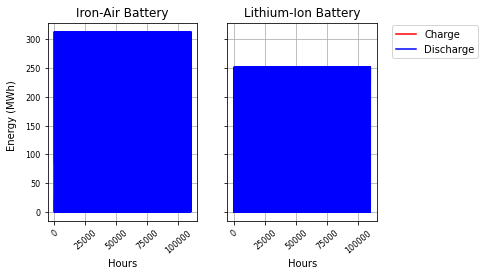

In [152]:
fig,ax = plt.subplots(1, 2, figsize = set_size(width), sharey=True)

#apparently have to draw the canvas before it can get ticks?
fig.canvas.draw()

for i in range(len(storage_ops)):
    ax[i].set_xlabel("Hours", fontsize = 10)
    ax[i].grid(True)
    ax[i].set_title(names[i], fontsize=12)
    ax[i].plot(opt_results[i][1], label='Charge', color='red')
    ax[i].plot(opt_results[i][2], label='Discharge', color='blue')
    plt.draw()
    labels = ax[i].get_xticklabels()
    ax[i].set_xticklabels(labels, rotation=40, fontsize=8)
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].tick_params(axis='y', labelsize=8)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))

fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(0.65, 0, 0.5, 0.89))
fig.text(0.03, 0.4, "Energy (MWh)", fontsize=10, rotation='vertical')
# Save and remove excess whitespace
fig.savefig('images/iron_li_peform.png', format='png', dpi=500, bbox_inches='tight')
plt.show()


<ipython-input-153-d8ea68bcac44>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels, rotation=40, fontsize=8)


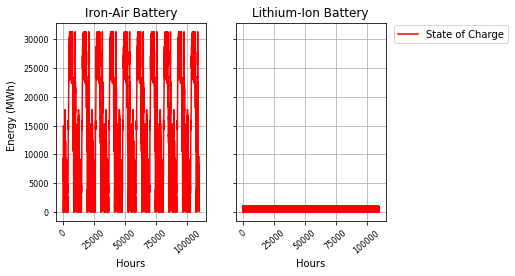

In [153]:
fig,ax = plt.subplots(1, 2, figsize = set_size(width), sharey=True)

#apparently have to draw the canvas before it can get ticks?
fig.canvas.draw()

for i in range(len(storage_ops)):
    ax[i].set_xlabel("Hours", fontsize = 10)
    ax[i].grid(True)
    ax[i].set_title(names[i], fontsize=12)
    ax[i].plot(opt_results[i][0], label='State of Charge', color='red')
    plt.draw()
    labels = ax[i].get_xticklabels()
    ax[i].set_xticklabels(labels, rotation=40, fontsize=8)
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].tick_params(axis='y', labelsize=8)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(0.7, 0, 0.5, 0.89))
fig.text(0.01, 0.4, "Energy (MWh)", fontsize=10, rotation='vertical')
fig.savefig('images/iron_li_soc.png', format='png', dpi=500,  bbox_inches='tight')
plt.show()